In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.stats import skew
import shap

SEED = 2899
tf.random.set_seed(SEED)

TRAIN = True

train_data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
submission_data = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

print(train_data.describe())

print(f"Train dataset size: {len(train_data)}")
print(f"Submission dataset size: {len(submission_data)}")

if TRAIN:
    submission_data = None

               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000  
Train dataset size: 8693
Submission dataset size: 4277


# Exploratory Data Analysis

## Data Types

In [2]:
train_data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [3]:
categorical_variables = train_data.select_dtypes(include="object").columns
numerical_variables = train_data.select_dtypes(include="number").columns

## Distribution of Variables

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


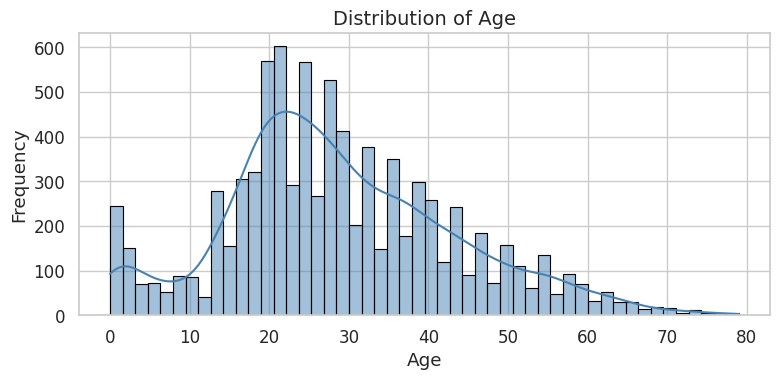

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


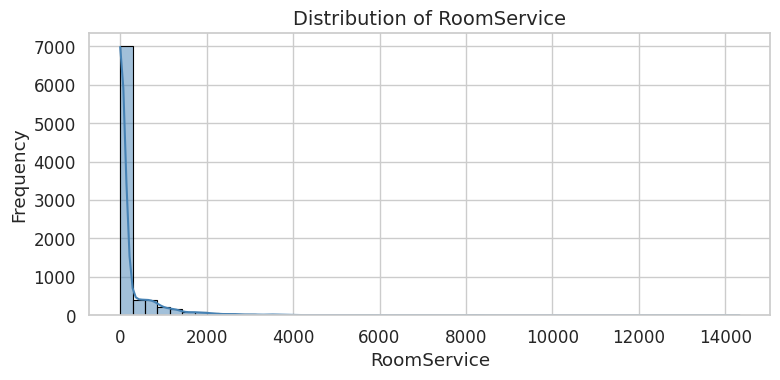

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


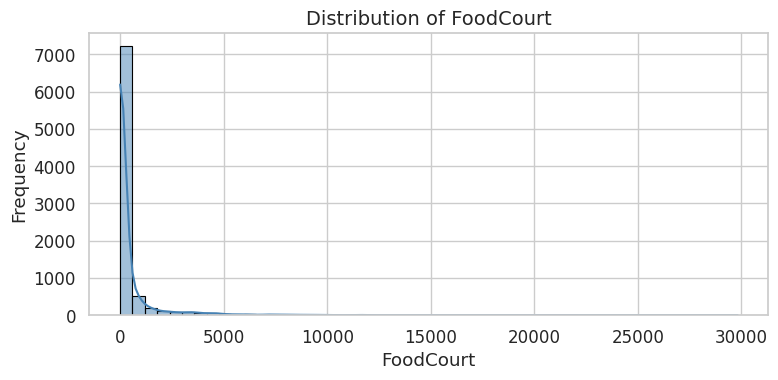

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


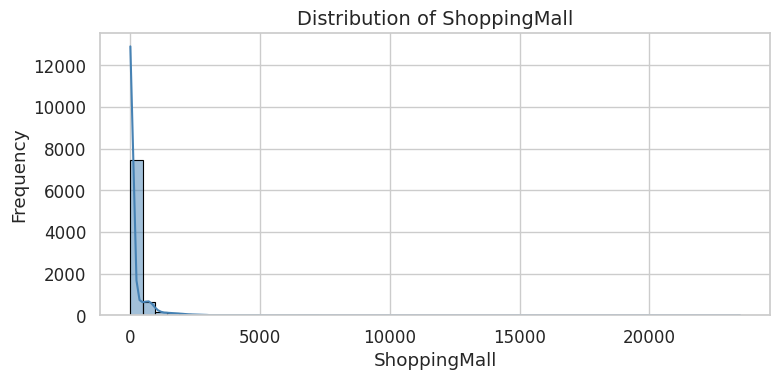

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


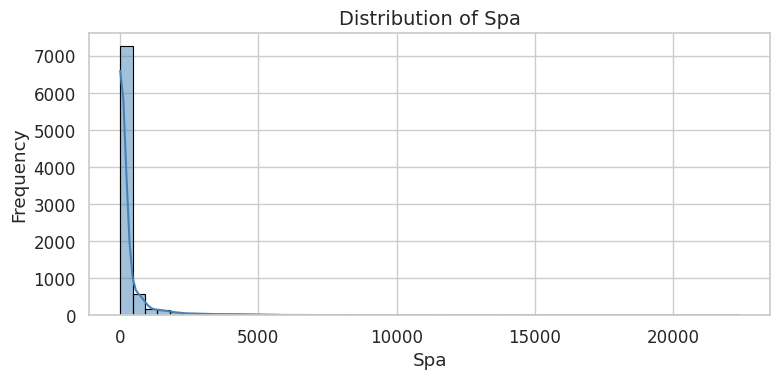

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


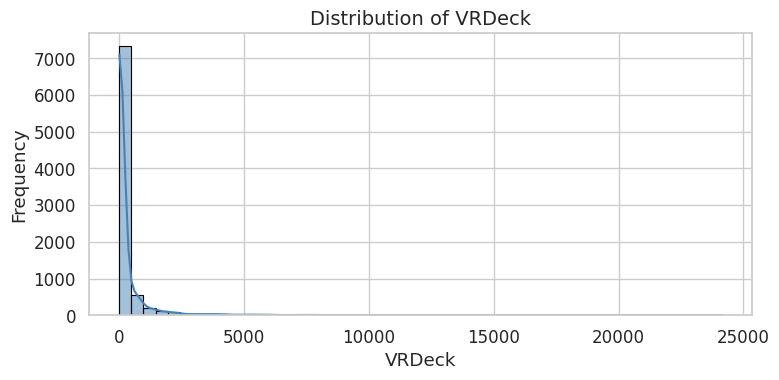

In [4]:
def numerical_distribution(dataset):
    sns.set(style="whitegrid", palette="muted", font_scale=1.1)

    for column in dataset.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(data=dataset, x=column, bins=50, kde=True, color="steelblue", edgecolor="black")
        plt.title(f"Distribution of {column}", fontsize=14)
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

numerical_distribution(train_data[numerical_variables])

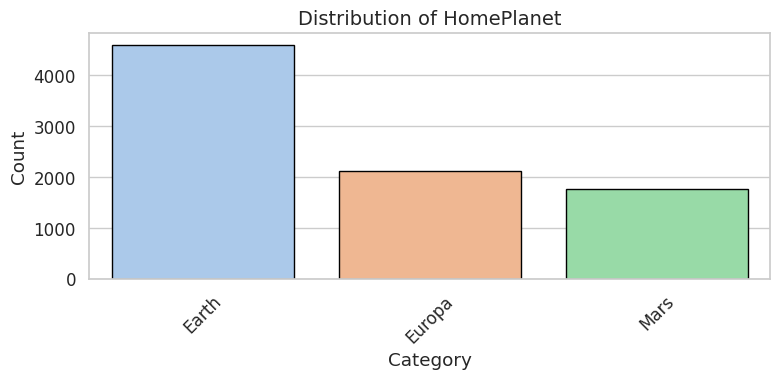

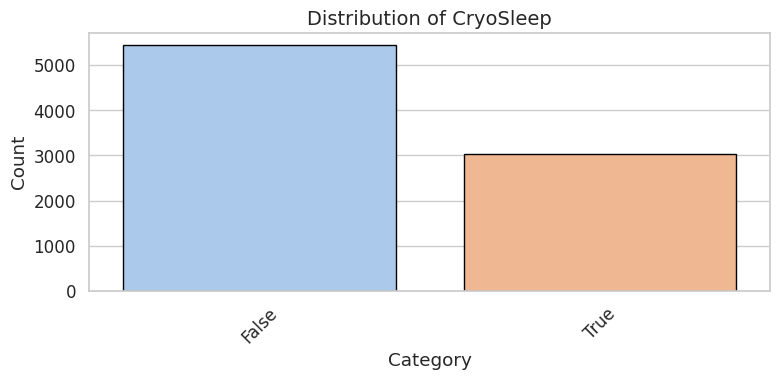

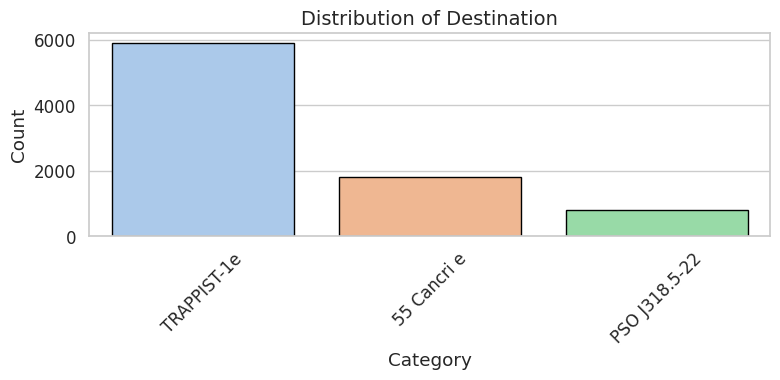

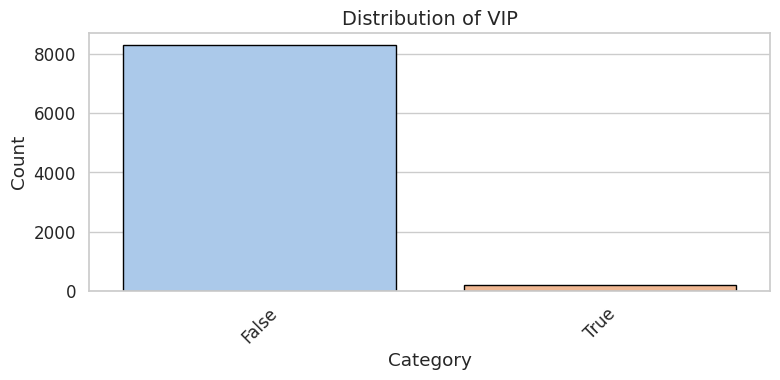

In [5]:
def categorical_distribution(dataset):
    sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

    columns = [column for column in dataset.columns if column not in ["PassengerId", "Name", "Cabin"]]

    for column in columns:
        plt.figure(figsize=(8, 4))
        order = dataset[column].value_counts().index
        sns.countplot(data=dataset, x=column, order=order, edgecolor="black")
        plt.title(f"Distribution of {column}", fontsize=14)
        plt.xlabel("Category")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

categorical_distribution(train_data[categorical_variables])

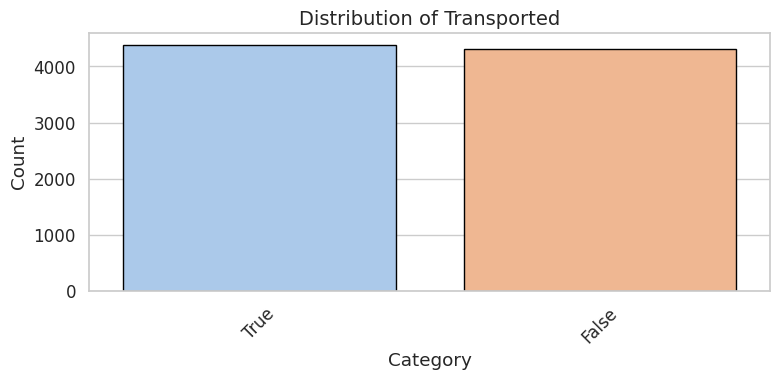

In [6]:
categorical_distribution(train_data[["Transported"]])

## Distribution of Variables By Target Variable

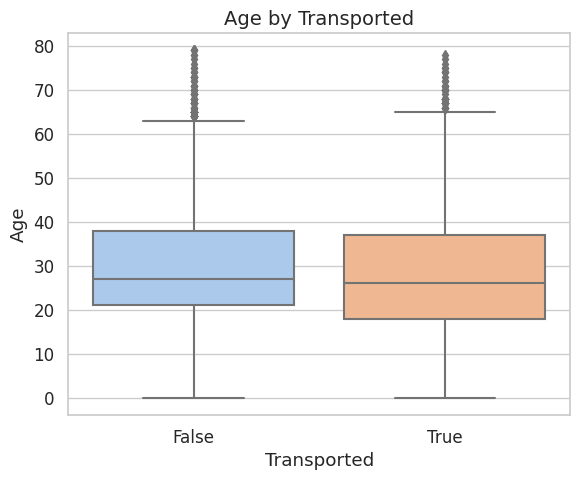

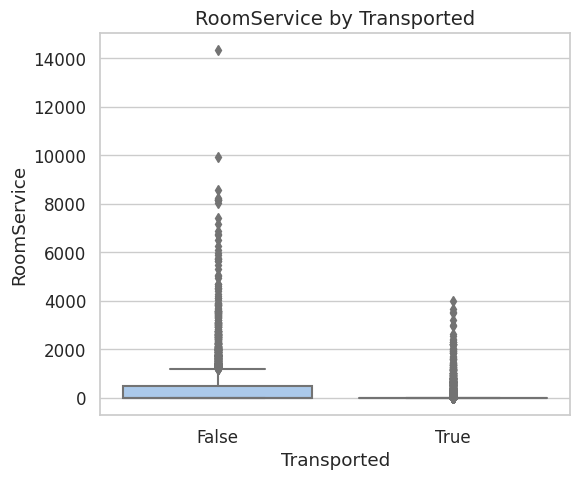

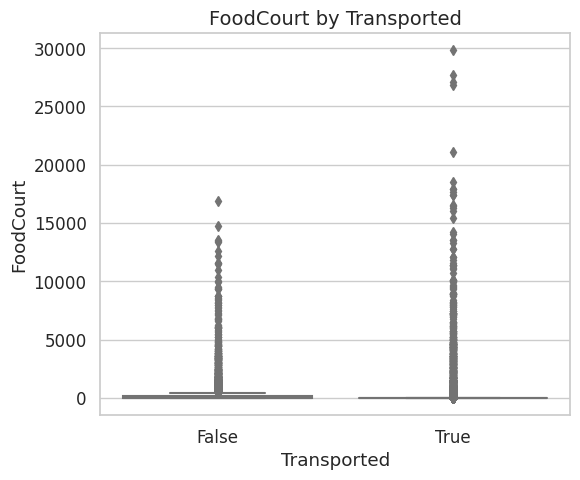

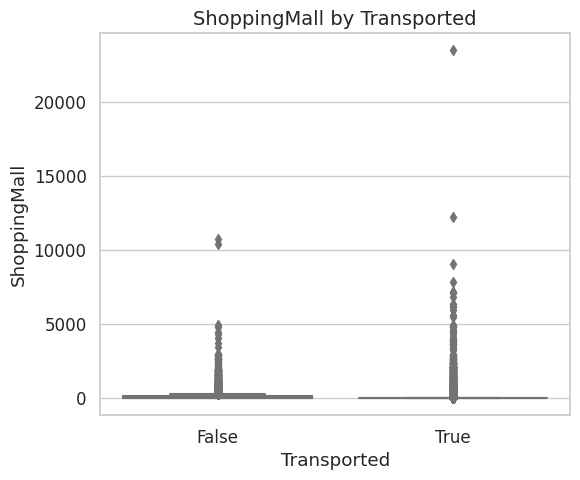

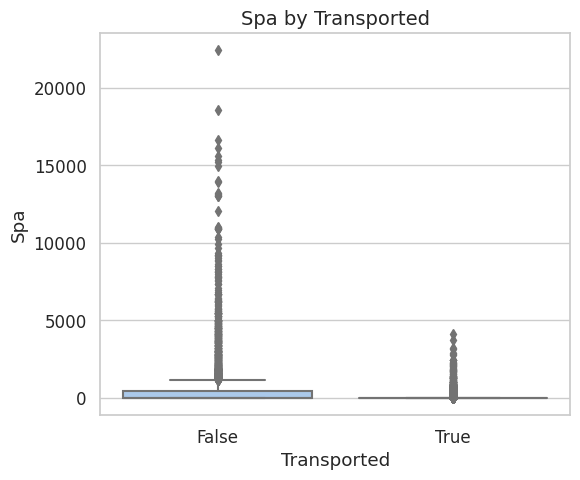

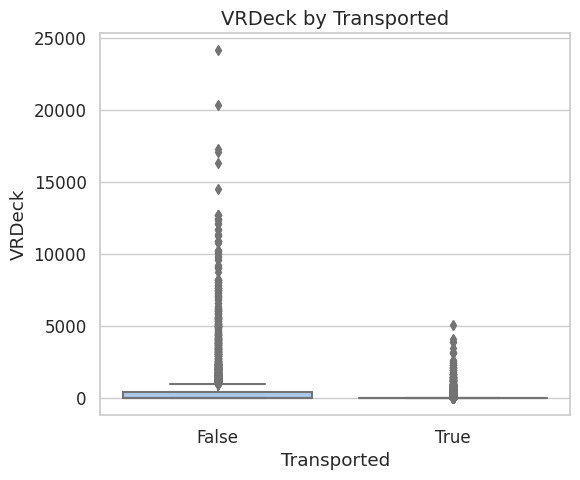

In [7]:
def numerical_distribution_over_target(dataset):
    sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

    columns = [column for column in dataset.columns if column != "Transported"]

    for column in columns:
        plt.figure(figsize=(6, 5))
        sns.boxplot(
            data=dataset,
            x="Transported",
            y=column,
            palette="pastel",
            linewidth=1.5
        )
        plt.title(f"{column} by Transported", fontsize=14)
        plt.xlabel("Transported")
        plt.ylabel(column)
        plt.tight_layout()
        plt.show()

numerical_distribution_over_target(train_data[[*numerical_variables, "Transported"]])

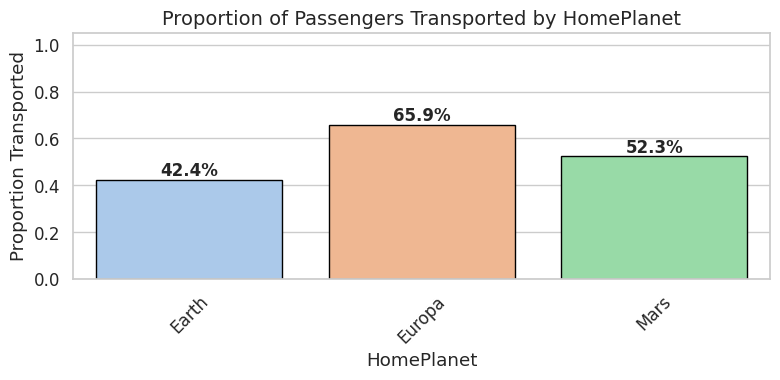

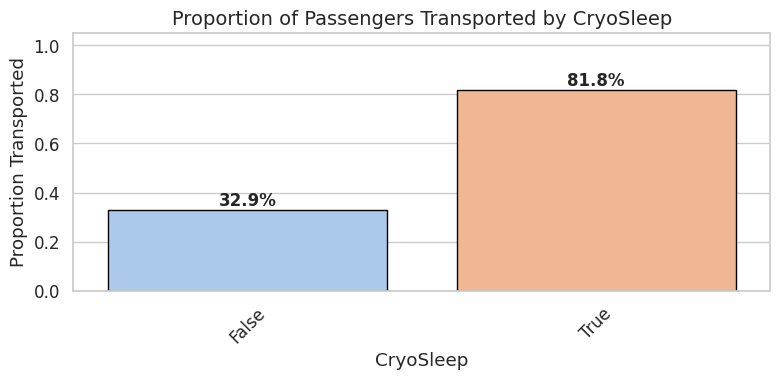

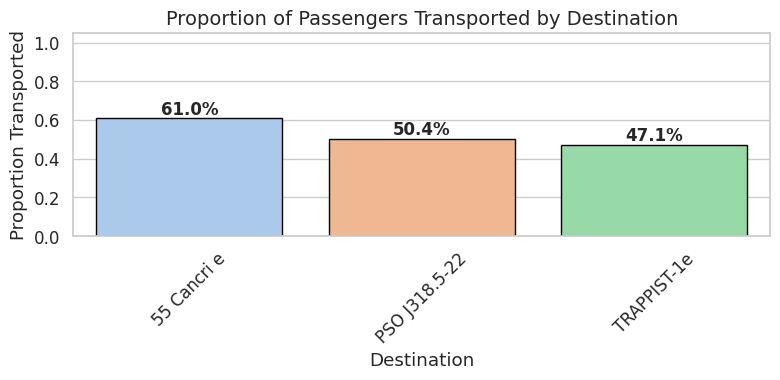

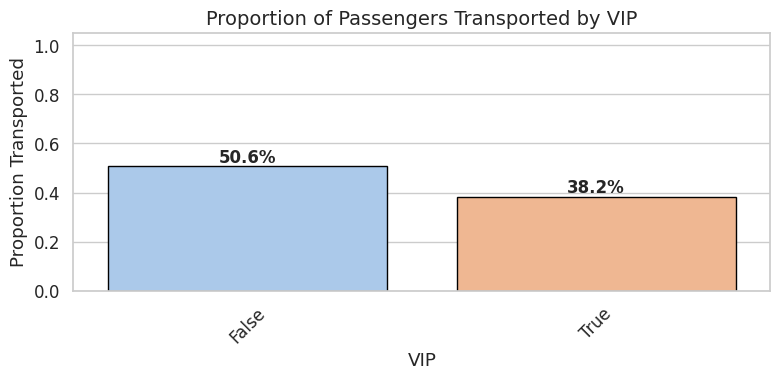

In [8]:
def categorical_distribution_over_target(dataset):
    sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

    columns = [column for column in dataset.columns if column not in ["PassengerId", "Name", "Cabin", "Transported"]]

    for column in columns:
        plt.figure(figsize=(8, 4))
        prop_data = (
            dataset
            .groupby(column)["Transported"]
            .mean()
            .reset_index()
            .rename(columns={"Transported": "Proportion"})
        )

        ax = sns.barplot(
            data=prop_data,
            x=column,
            y="Proportion",
            palette="pastel",
            edgecolor="black"
        )

        # Add larger percentage labels
        for p in ax.patches:
            height = p.get_height()
            if not pd.isna(height):
                ax.annotate(
                    f"{height:.1%}",
                    (p.get_x() + p.get_width() / 2., height),
                    ha="center",
                    va="bottom",
                    fontsize=12,
                    fontweight="bold"
                )

        plt.title(f"Proportion of Passengers Transported by {column}", fontsize=14)
        plt.xticks(rotation=45)
        plt.xlabel(column)
        plt.ylabel("Proportion Transported")
        plt.ylim(0, 1.05)
        plt.tight_layout()
        plt.show()

categorical_distribution_over_target(train_data[[*categorical_variables, "Transported"]])

## Missing Values

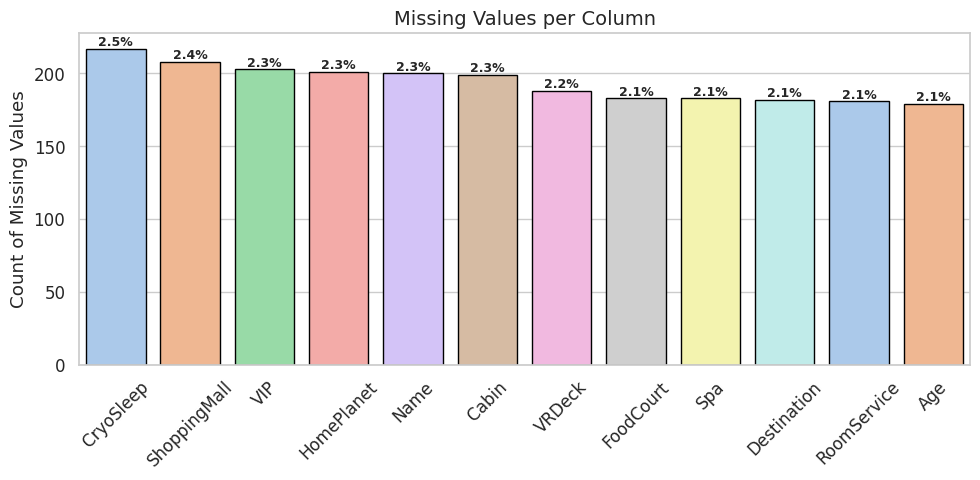

Rows with at least one missing value: 2087/8693


In [9]:
def missing_values(dataset):
    sns.set(style="whitegrid", font_scale=1.1)

    missing_counts = dataset.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
    missing_percent = (missing_counts / len(dataset)) * 100

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(
        x=missing_counts.index,
        y=missing_counts.values,
        palette="pastel",
        edgecolor="black"
    )
    plt.title("Missing Values per Column", fontsize=14)
    plt.ylabel("Count of Missing Values")
    plt.xticks(rotation=45)

    for patch, percent in zip(ax.patches, missing_percent):
        height = patch.get_height()
        if not pd.isna(height):
            ax.annotate(
                f"{percent:.1f}%",
                (patch.get_x() + patch.get_width() / 2., height),
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold"
            )

    plt.tight_layout()
    plt.show()

    num_rows_with_missing = dataset.isnull().any(axis=1).sum()
    print(f"Rows with at least one missing value: {num_rows_with_missing}/{len(dataset)}")

missing_values(train_data)

## Correlations

invalid value encountered in less


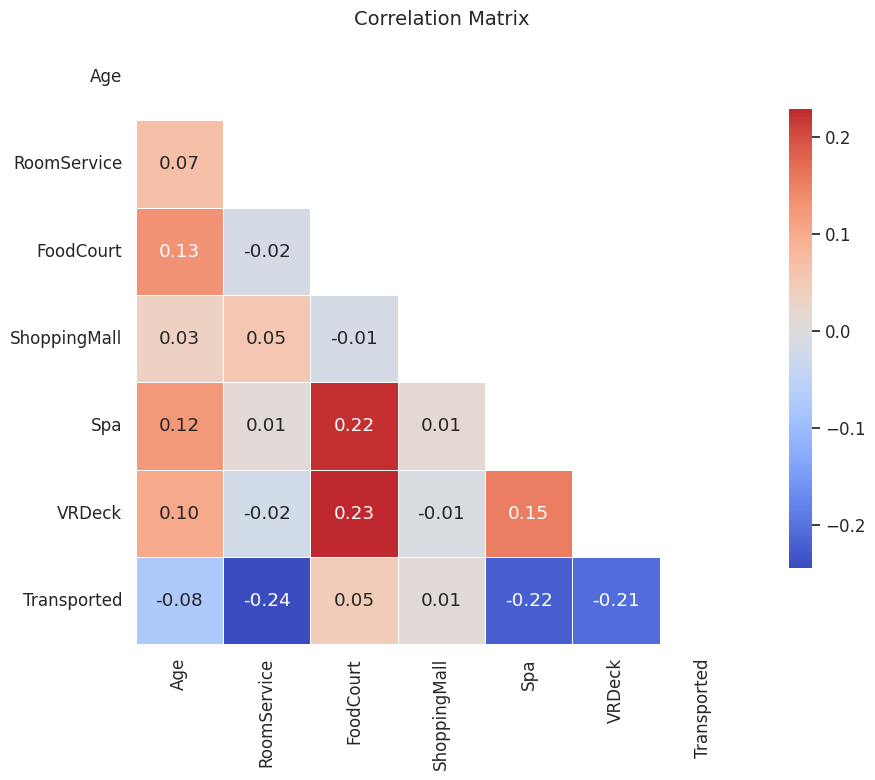

In [10]:
def correlations(dataset):
    sns.set(style="white", font_scale=1.1)

    corr = dataset.corr(numeric_only=True)

    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr, dtype=bool))  # hide upper triangle

    sns.heatmap(
        corr,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75}
    )

    plt.title("Correlation Matrix", fontsize=14)
    plt.tight_layout()
    plt.show()

correlations(train_data)

## Pre-Processing

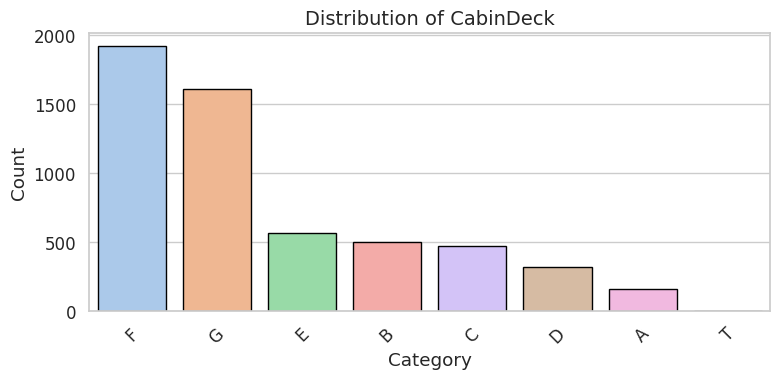

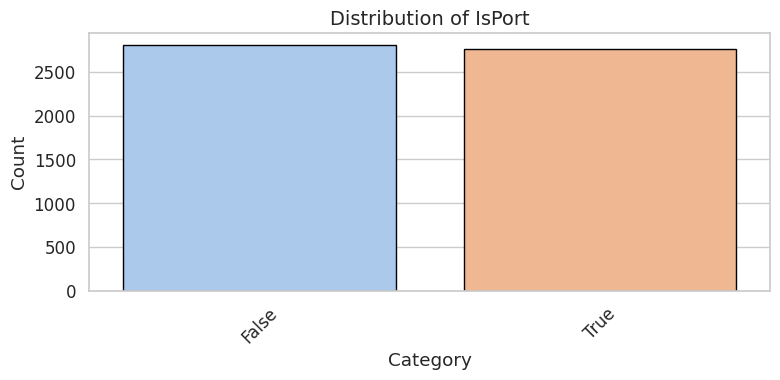

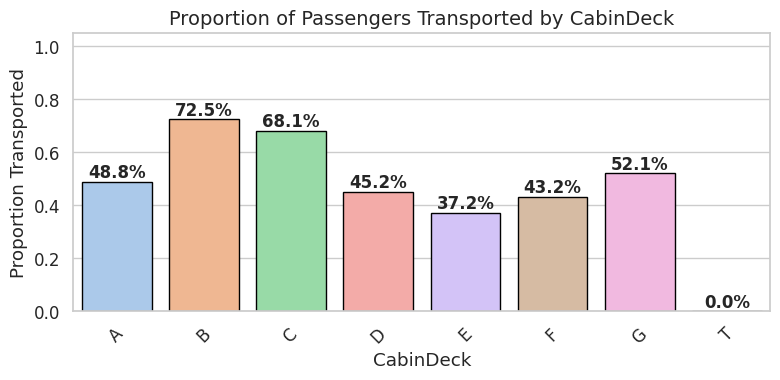

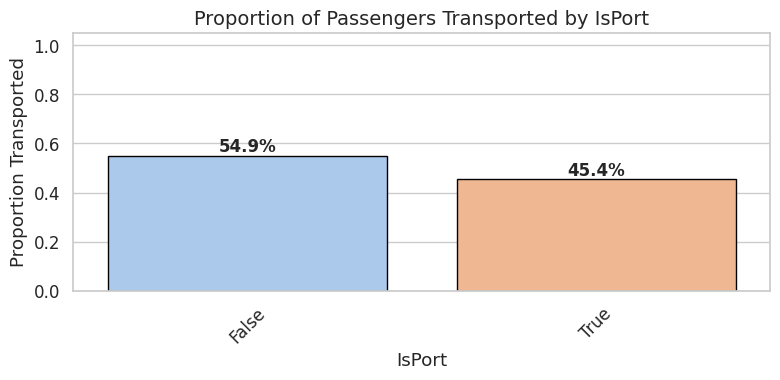

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


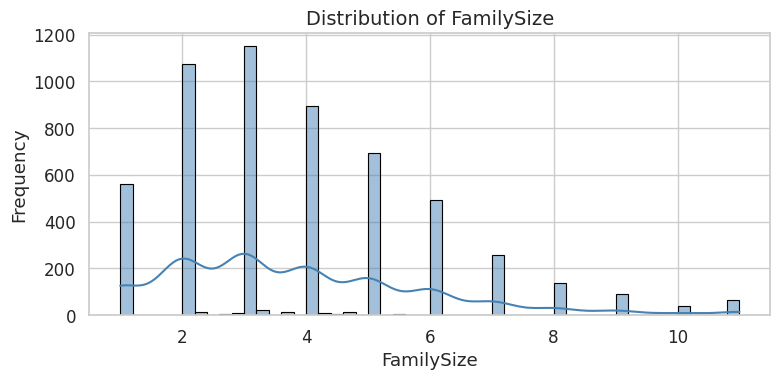

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


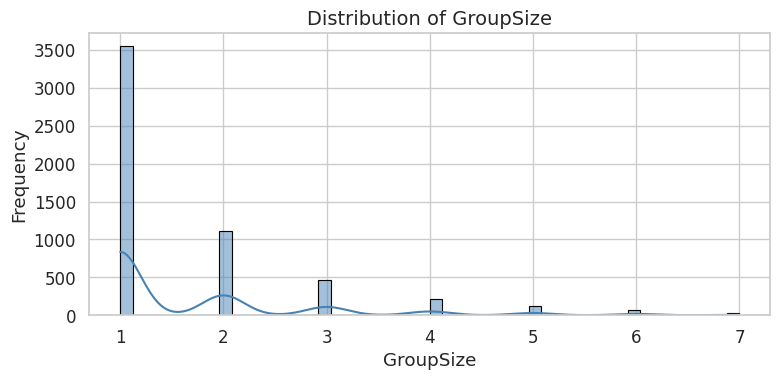

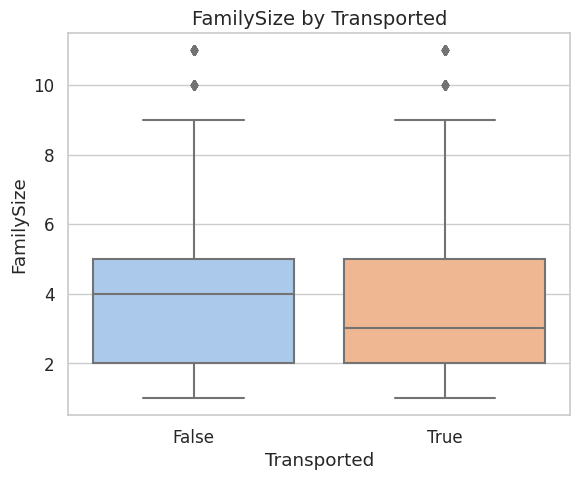

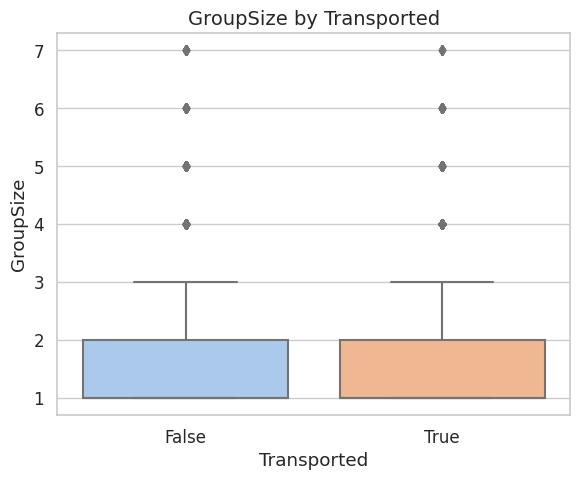

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


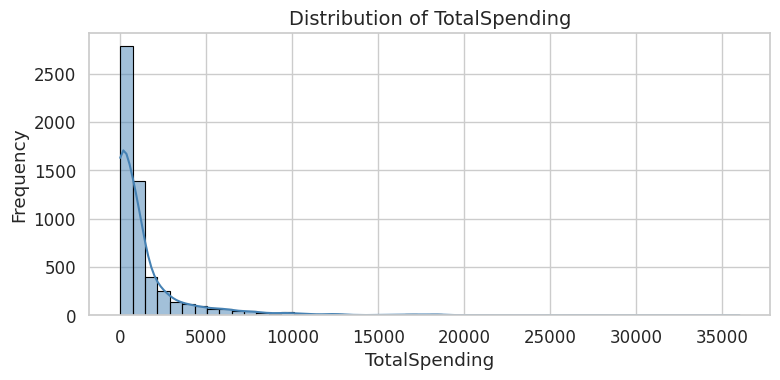

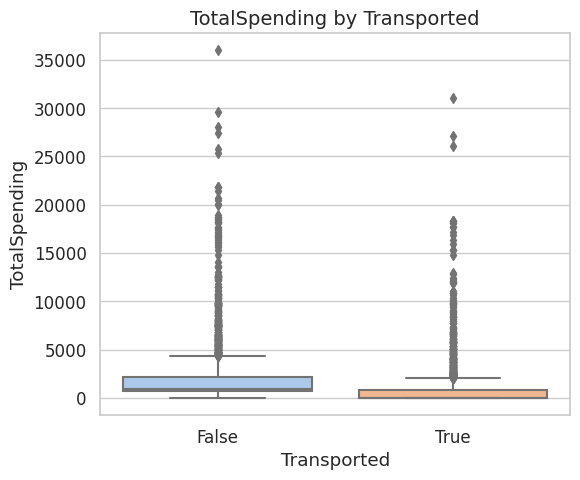

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


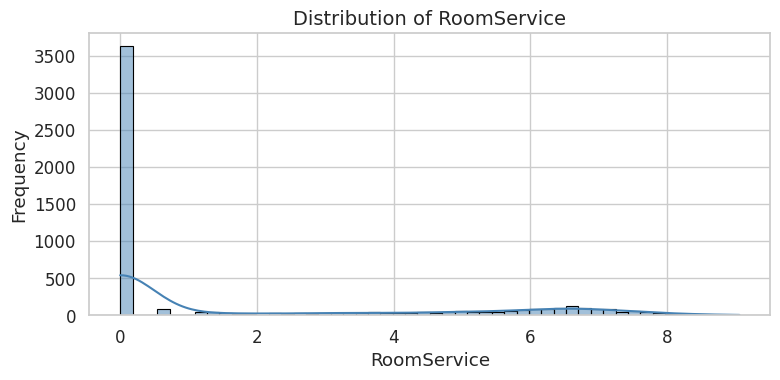

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


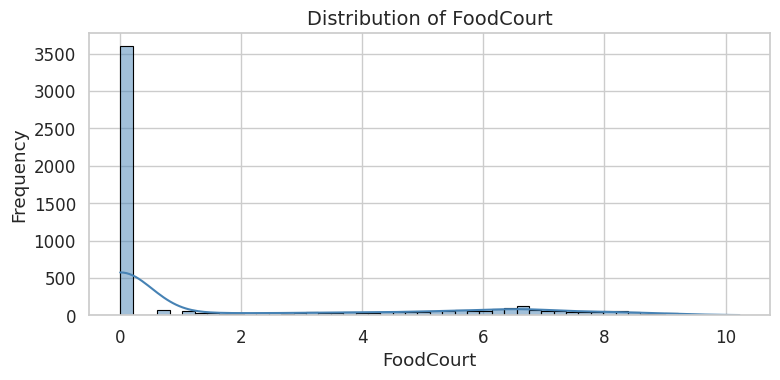

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


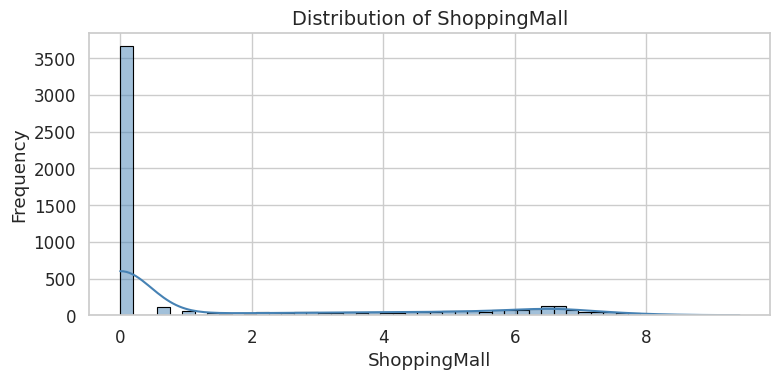

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


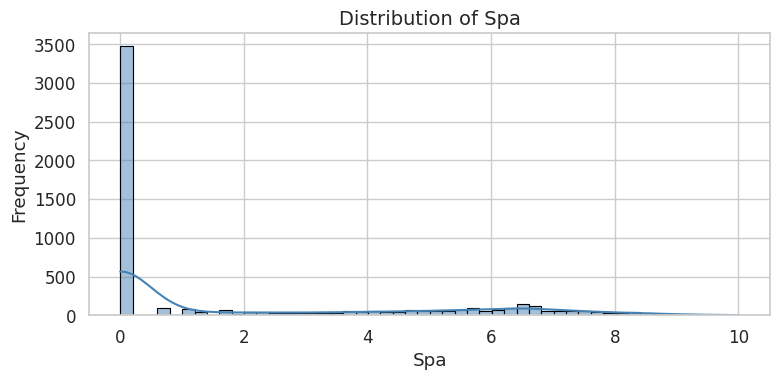

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


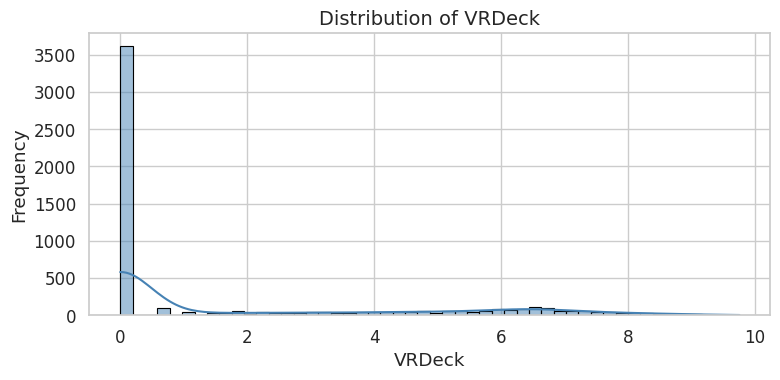

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


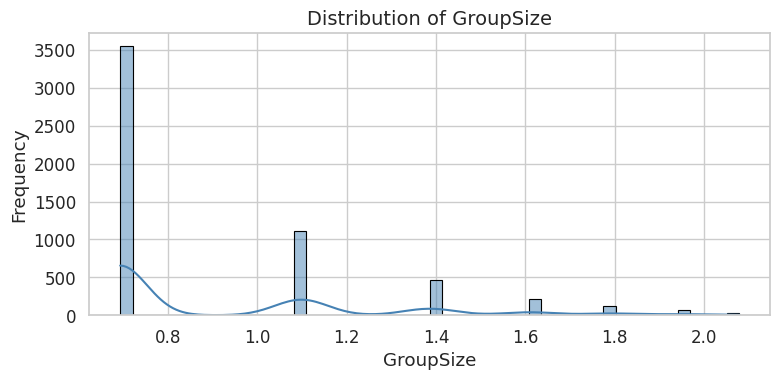

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


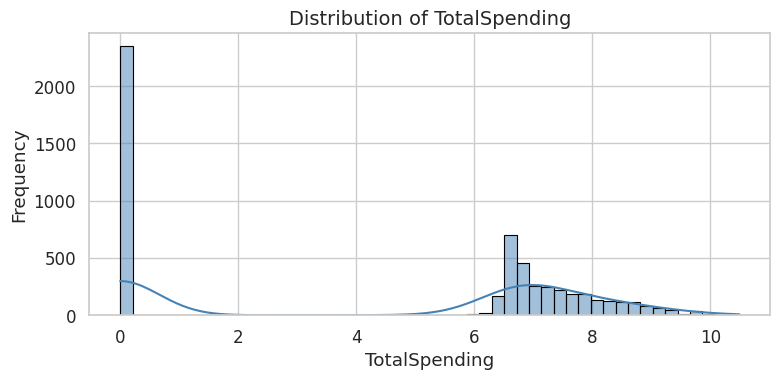

In [11]:
def pre_process(dataset, submission_dataset=None):
    # Split before pre-processing to avoid data leakage due to transformations
    train_data, validation_data, test_data = split_dataset(dataset, submission_dataset)

    train_data = pre_feature_engineering(train_data)
    validation_data = pre_feature_engineering(validation_data)
    test_data = pre_feature_engineering(test_data)

    train_data, knn_imputer, mode_imputer = impute_missing_values(train_data)
    validation_data, _, _ = impute_missing_values(validation_data, knn_imputer, mode_imputer)
    test_data, _, _ = impute_missing_values(test_data, knn_imputer, mode_imputer)

    categorical_distribution(train_data[["CabinDeck", "IsPort"]])
    categorical_distribution_over_target(train_data[["CabinDeck", "IsPort", "Transported"]])

    numerical_distribution(train_data[["FamilySize", "GroupSize"]])
    numerical_distribution_over_target(train_data[["FamilySize", "GroupSize", "Transported"]])

    # Tried removing outliers, but it only worsened the results.

    train_data = post_feature_engineering(train_data)
    validation_data = post_feature_engineering(validation_data)
    test_data = post_feature_engineering(test_data)

    numerical_distribution(train_data[["TotalSpending"]])
    numerical_distribution_over_target(train_data[["TotalSpending", "Transported"]])

    train_data, corrected_variables = correct_skewness(train_data)
    validation_data, _ = correct_skewness(validation_data)
    test_data, _ = correct_skewness(test_data)

    numerical_distribution(train_data[corrected_variables])

    train_data, scaler = standardize_numerical(train_data)
    validation_data, _ = standardize_numerical(validation_data, scaler)
    test_data, _ = standardize_numerical(test_data, scaler)

    train_data, encoder = encode_categorical(train_data)
    validation_data, _ = encode_categorical(validation_data, encoder)
    test_data, _ = encode_categorical(test_data, encoder)

    x_train, y_train = x_y(train_data)
    x_validation, y_validation = x_y(validation_data)
    x_test, y_test = x_y(test_data)

    return x_train, y_train, x_validation, y_validation, x_test, y_test

def split_dataset(dataset, submission_dataset=None):
    train_data = dataset
    test_data = submission_dataset

    if test_data is None:
        # Training + Validation and testing 80/20
        train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=SEED)

    # Training and Validation 80/20
    train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=SEED)

    return train_data, validation_data, test_data

def pre_feature_engineering(dataset):
    # Replace cabin feature with more specific features
    dataset[["CabinDeck", "CabinNum", "CabinSide"]] = dataset["Cabin"].str.split("/", expand=True)
    dataset["CabinNum"] = dataset["CabinNum"]
    dataset = dataset.drop("Cabin", axis=1)

    # Split name in first name and last name
    # Will be used for family matching by last name
    dataset[["FirstName", "LastName"]] = dataset["Name"].str.split(" ", expand=True)
    dataset = dataset.drop("Name", axis=1)

    # Create family size variable
    family_sizes = dataset.groupby("LastName")["PassengerId"].count().rename("FamilySize")
    dataset["FamilySize"] = dataset["LastName"].map(family_sizes)

    # Create group ID feature
    dataset["GroupID"] = dataset["PassengerId"].apply(lambda x: x.split("_")[0])

    # Create group size variable
    group_sizes = dataset.groupby("GroupID")["PassengerId"].count().rename("GroupSize")
    dataset["GroupSize"] = dataset["GroupID"].map(group_sizes)

    # Convert binary category into binary variable to reduce dimensionality
    dataset["IsPort"] = dataset["CabinSide"].map({"P": True, "S": False})
    dataset = dataset.drop("CabinSide", axis=1)

    # Cast bools to binary for imputation
    dataset[["IsPort", "CryoSleep", "VIP"]] = dataset[["IsPort", "CryoSleep", "VIP"]].astype("Int64")

    # Drop variables with high cardinality
    dataset = dataset.drop(["CabinNum", "FirstName", "LastName", "PassengerId", "GroupID"], axis=1)

    return dataset

def impute_missing_values(dataset, knn_imputer=None, mode_imputer=None):
    numerical_columns = dataset.select_dtypes(include="number").columns

    if knn_imputer is None:
        knn_imputer = KNNImputer(n_neighbors=5)
        knn_imputer.fit(dataset[numerical_columns])

    dataset[numerical_columns] = knn_imputer.transform(dataset[numerical_columns])

    categorical_columns = dataset.select_dtypes(include="object").columns

    if mode_imputer is None:
        mode_imputer = SimpleImputer(strategy="most_frequent")
        mode_imputer.fit(dataset[categorical_columns])

    dataset[categorical_columns] = mode_imputer.transform(dataset[categorical_columns])

    # Cast binary to bools
    dataset[["IsPort", "CryoSleep", "VIP"]] = dataset[["IsPort", "CryoSleep", "VIP"]].round().astype(bool)

    return dataset, knn_imputer, mode_imputer

def post_feature_engineering(dataset):
    # Create total spending feature
    dataset["TotalSpending"] = dataset["RoomService"] + dataset["FoodCourt"] + dataset["ShoppingMall"] + dataset["Spa"] + dataset["VRDeck"]

    return dataset

def correct_skewness(dataset):
    numerical_columns = dataset.select_dtypes(include="number").columns
    skews = dataset[numerical_columns].apply(lambda x: skew(x.dropna()))
    skewed_columns = skews[skews > 1].index

    for column in skewed_columns:
        dataset[column] = np.log1p(dataset[column])

    return dataset, skewed_columns

def standardize_numerical(dataset, scaler=None):
    numerical_columns = dataset.select_dtypes(include="number").columns

    scaler = StandardScaler() if scaler is None else scaler
    scaled = scaler.fit_transform(dataset[numerical_columns])

    scaled_dataframe = pd.DataFrame(scaled, columns=numerical_columns, index=dataset.index)

    dataset[numerical_columns] = scaled_dataframe

    return dataset, scaler

def encode_categorical(dataset, encoder=None):
    categorical_columns = dataset.select_dtypes(include="object").columns
    remaining_columns = dataset.columns.difference(categorical_columns)

    if encoder is None:
        encoder = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
        encoder.fit(dataset[categorical_columns])

    encoded_columns = encoder.get_feature_names_out(categorical_columns)

    encoded_dataset = encoder.transform(dataset[categorical_columns])
    encoded_dataframe = pd.DataFrame(encoded_dataset, columns=encoded_columns, index=dataset.index)

    dataset = pd.concat([dataset[remaining_columns], encoded_dataframe], axis=1)

    return dataset, encoder

# Separates Xs and Y
def x_y(x):
    y = None

    if "Transported" in x:
        y = x["Transported"].astype(int)
        x = x.drop("Transported", axis=1)

    return x, y

x_train, y_train, x_validation, y_validation, x_test, y_test = pre_process(train_data, submission_data)

# Training

(just the optimized model)

In [12]:
model = LGBMClassifier(
    random_state=SEED,
    n_estimators=337,
    learning_rate=0.024230875709953033,
    max_depth=9,
    num_leaves=26,
    subsample=0.9242197257138703,
    colsample_bytree=0.6030490088823314,
    min_child_samples=18,
)

model.fit(
    x_train,
    y_train,
    eval_set=[(x_validation, y_validation)],
    eval_metric="binary_logloss"
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2792, number of negative: 2771
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1685
[LightGBM] [Info] Number of data points in the train set: 5563, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501887 -> initscore=0.007550
[LightGBM] [Info] Start training from score 0.007550


LGBMClassifier(colsample_bytree=0.6030490088823314,
               learning_rate=0.024230875709953033, max_depth=9,
               min_child_samples=18, n_estimators=337, num_leaves=26,
               random_state=2899, subsample=0.9242197257138703)

Accuracy: 0.7924094307073031
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       863
           1       0.79      0.81      0.80       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



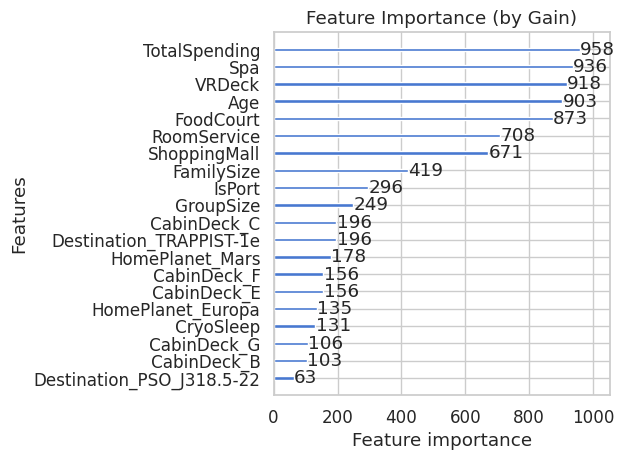

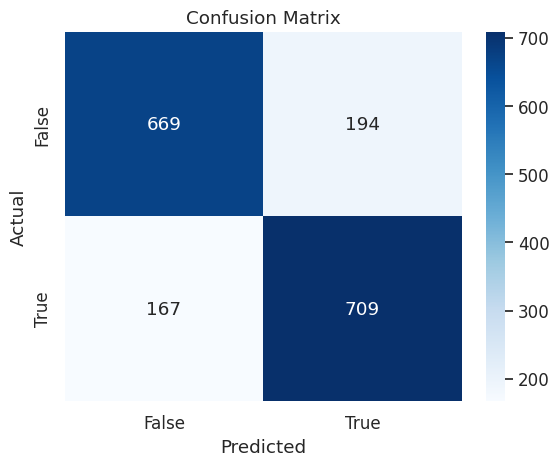

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


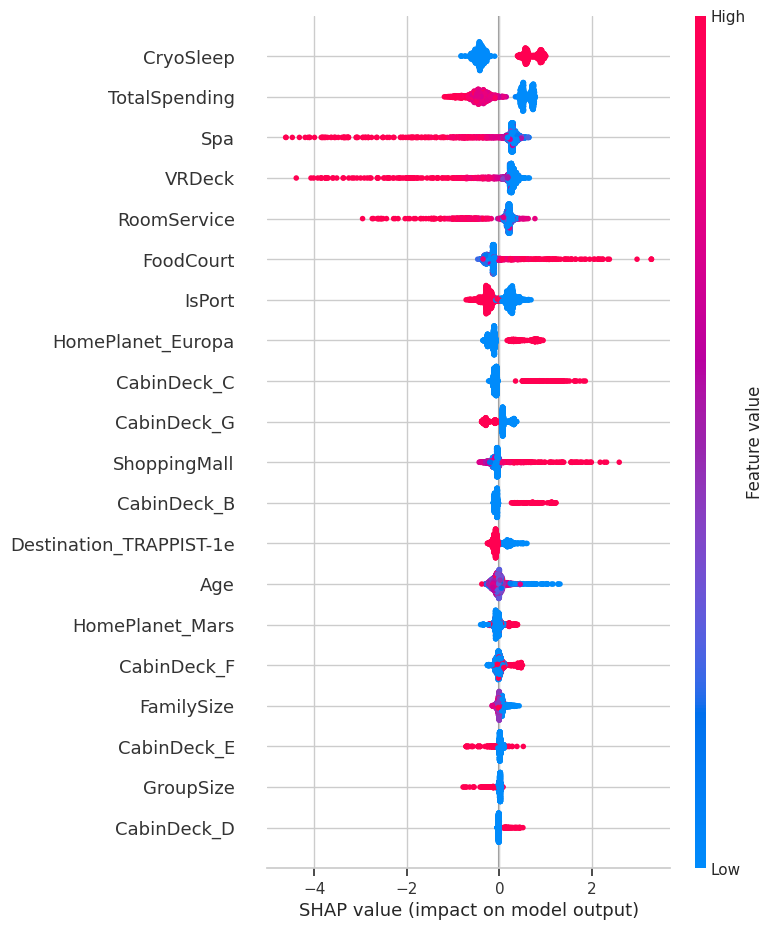

In [14]:
def attempt_submission(model):
    y_prediction = model.predict(x_test)

    predicted_labels = (y_prediction > 0.5).astype(bool).flatten()

    submission = pd.DataFrame({
        "PassengerId": submission_data["PassengerId"],
        "Transported": predicted_labels
    })

    submission.to_csv("submission.csv", index=False)

def get_best_model(models):
    best_model = None
    best_accuracy = 0

    for model in models:
        y_prediction = model.predict(x_test)
        predicted_labels = (y_prediction > 0.5).astype(bool).flatten()

        accuracy = accuracy_score(y_test, predicted_labels)

        print("Accuracy:", accuracy)
        print(classification_report(y_test, predicted_labels))

        if accuracy > best_accuracy:
            best_model = model
            best_accuracy = accuracy

    return best_model

def model_results(model):
    y_prediction = model.predict(x_test)
    predicted_labels = (y_prediction > 0.5).astype(bool).flatten()

    accuracy = accuracy_score(y_test, predicted_labels)

    print("Accuracy:", accuracy)
    print(classification_report(y_test, predicted_labels))

    plot_importance(model, max_num_features=20)
    plt.title("Feature Importance (by Gain)")
    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_test, predicted_labels)

    cm_df = pd.DataFrame(cm, index=["False", "True"], columns=["False", "True"])

    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    shap_values = shap.TreeExplainer(model).shap_values(x_test)
    shap.summary_plot(shap_values[1], x_test)

if TRAIN:
    model_results(model)
else:
    attempt_submission(model)